In [7]:
import numpy as np
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## outline
- [1. Data preprocessing](#1)

  - [1.1 import the train.csv. ](#1-1)
  - [1.2 missing data processing](#1-2)
  - [1.3 Feature selection](#1-3)
  - [1.4 Noramlization & One-hot encoding](#1-4)

<a name='1'></a>
# 1. Data preprocessing

<a name='1-1'></a>
## 1.1 import the train.csv. 
In this part, data will be imported into notebook then we will check the info of this raw dataset.


In [8]:
# import dataset as well as print previous 5 rows of data.
raw_data = pd.read_csv('train.csv')
raw_data.head()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,2718481,1933325,3,2006,1997,R,R.20,R.20.6,B,?,...,-1.054747,-1.164837,-0.812472,-0.581756,N,-0.23153,-0.266117,2.715490,-0.251419,104.597500
1,6717427,4297298,1,2006,1997,BF,BF.35,BF.35.1,F,?,...,-1.149901,-1.299354,-1.193388,-1.323992,N,-0.23153,2.783616,-0.272337,-0.251419,0.000000
2,7218252,4708245,1,2006,2000,M,M.16,M.16.1,B,C,...,-0.775231,-1.467792,-0.947636,-0.914860,F,-0.23153,-0.266117,-0.272337,-0.251419,0.000000
3,8048505,5136981,7,2007,2003,BH,BH.22,BH.22.0,B,C,...,-0.751442,-0.378792,-0.689596,0.730640,M,-0.23153,-0.266117,-0.272337,-0.251419,0.000000
4,3209482,2151306,5,2006,2001,BW,BW.167,BW.167.0,I,C,...,0.461775,1.451805,1.411586,0.977104,B,-0.23153,-0.266117,-0.272337,-0.251419,0.615937


In [9]:
# check the information of each column, so that we know which columns are discrete data.
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row_ID          30000 non-null  int64  
 1   Household_ID    30000 non-null  int64  
 2   Vehicle         30000 non-null  int64  
 3   Calendar_Year   30000 non-null  int64  
 4   Model_Year      30000 non-null  int64  
 5   Blind_Make      30000 non-null  object 
 6   Blind_Model     30000 non-null  object 
 7   Blind_Submodel  30000 non-null  object 
 8   Cat1            30000 non-null  object 
 9   Cat2            30000 non-null  object 
 10  Cat3            30000 non-null  object 
 11  Cat4            30000 non-null  object 
 12  Cat5            30000 non-null  object 
 13  Cat6            30000 non-null  object 
 14  Cat7            30000 non-null  object 
 15  Cat8            30000 non-null  object 
 16  Cat9            30000 non-null  object 
 17  Cat10           30000 non-null 

<a name='1-2'></a>
## 1.2 missing data processing

In this part, we will process the missing data. There two kinds of data that we will handle. The first one is  continuous number ( roughly, I take the row_id as continuous data. ), the other one is discrete number. 

a). For continuous data, the missing data will be replaced by the average of the values of the corresponding column. The reason why we choose the average as the replacement of missing data is that mean of data would not affect the distribution of the dataset.

b). Respect to the discrete data, the missing data will be replaced by the category that appears most frequently in the corresponding column.


In [10]:
# separate the columns into continuous and discrete groups
continous_columns = set(raw_data.describe().columns)
discrete_columns = set(raw_data.columns).difference(set(raw_data.describe().columns))

count  missing data of each column.

In [11]:
# the number of the total dataset
N = raw_data.shape[0]
missing_data_con_info= []
missing_data_dis_info= []
for column_name in discrete_columns:
    num = raw_data[raw_data[column_name]=='?'].shape[0]/N
    missing_data_dis_info.append([column_name,num])
    
for column_name in continous_columns:
    num = raw_data[raw_data[column_name]==np.NaN].shape[0]/N
    missing_data_con_info.append([column_name,num])
    
missing_data_con_info = pd.DataFrame(missing_data_con_info,columns=['column', 'proportion of missing continuous data'])


missing_data_dis_info = pd.DataFrame(missing_data_dis_info,columns=['column', 'proportion of missing discrete data'])
missing_data_dis_info.sort_values(by=['proportion of missing discrete data'],ascending=False),missing_data_con_info.sort_values(by=['proportion of missing continuous data'],ascending=False)

(            column  proportion of missing discrete data
 13            Cat7                             0.549333
 12            Cat5                             0.433267
 1             Cat4                             0.432833
 2             Cat2                             0.353033
 11           Cat11                             0.001933
 8             Cat6                             0.001667
 4             Cat1                             0.001667
 3           OrdCat                             0.000633
 5       Blind_Make                             0.000500
 15     Blind_Model                             0.000500
 10  Blind_Submodel                             0.000500
 7             Cat3                             0.000367
 9            Cat10                             0.000333
 0             Cat8                             0.000067
 14            Cat9                             0.000000
 6            NVCat                             0.000000
 16           Cat12            

From the table above, we konw that the continuous features are well recorded which means there is no missing data for continuous features. However, discrete features miss a lot of data, so that `Cat7`, `Cat5`, `Cat4` and `Cat2` will be discarded beacuse they are missing too much data.

For the missing item, what we are going to do is that we will use mean of the column to replace the missing data in continuous features and use the most frequent data to replace the missing data in discrete features.

In [12]:
# drop the column that miss too much data
raw_data=raw_data.drop(['Cat7','Cat5','Cat4','Cat2'],axis=1)
discrete_columns = discrete_columns - set(['Cat7','Cat5','Cat4','Cat2'])

In [13]:
# copy the raw data, so that we can get a deep copy dataset.
raw_data_copy = raw_data.copy()

<br>
<br>
It looks like that missing item of discrete data have been indiced. However, there is a missing data that were not found.
`Cat12` has some missing data whose value are NaN. Thus, we have to replace these values by most frequent values of `Cat12`

In [14]:
discrete_value_count={}
for item in list(discrete_columns):
    discrete_value_count[item] = raw_data.loc[:,item].value_counts()

# replace the missing data
def missing_data_processing(data, discrete_value_count_dict):
    for itemkey in discrete_value_count_dict.keys():
        data.loc[:,itemkey][data.loc[:,itemkey]=='?'] = discrete_value_count_dict[itemkey].index[0]
        data.loc[:,itemkey][pd.isna(data.loc[:,itemkey])] = discrete_value_count_dict[itemkey].index[0]
         
    return data
    

In [15]:
raw_data_copy = missing_data_processing(raw_data_copy, discrete_value_count)
for item in list(discrete_columns):
    discrete_value_count[item] = raw_data_copy.loc[:,item].value_counts()
raw_data_copy.head()

C:\Users\physe\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\physe\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat3,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,2718481,1933325,3,2006,1997,R,R.20,R.20.6,B,A,...,-1.054747,-1.164837,-0.812472,-0.581756,N,-0.23153,-0.266117,2.715490,-0.251419,104.597500
1,6717427,4297298,1,2006,1997,BF,BF.35,BF.35.1,F,A,...,-1.149901,-1.299354,-1.193388,-1.323992,N,-0.23153,2.783616,-0.272337,-0.251419,0.000000
2,7218252,4708245,1,2006,2000,M,M.16,M.16.1,B,A,...,-0.775231,-1.467792,-0.947636,-0.914860,F,-0.23153,-0.266117,-0.272337,-0.251419,0.000000
3,8048505,5136981,7,2007,2003,BH,BH.22,BH.22.0,B,A,...,-0.751442,-0.378792,-0.689596,0.730640,M,-0.23153,-0.266117,-0.272337,-0.251419,0.000000
4,3209482,2151306,5,2006,2001,BW,BW.167,BW.167.0,I,B,...,0.461775,1.451805,1.411586,0.977104,B,-0.23153,-0.266117,-0.272337,-0.251419,0.615937


<br>
<br>

Then we separate the dataset into training dataset and validation dataset. Also, in this case, many values of Claim_Amount(label) are 0. Thus, we also have to process the Claim_Amount Column. What we going to do is that the values greater than 0 will be marked as 1, those values are equal to 0 will still keep 0.

In [16]:
# the 'Claim_Amount' column is removed since it is the label
#continous_columns.remove('Claim_Amount')

# raw_data_copy_X = raw_data_copy.drop(labels=['Claim_Amount'],axis=1)
raw_data_copy_X = raw_data_copy
raw_data_copy_Y = raw_data_copy.loc[:,'Claim_Amount']
raw_data_copy_Y_binary = raw_data_copy_Y.copy()
raw_data_copy_Y_binary[raw_data_copy_Y_binary>0]=1

<a name='1-3'></a>
## 1.3 Feature selection

Before the normalization, we need to select the feature we want.

We will process the numerical data. Standardization will be used as the method of data processing.

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

However, we cannot simply choose all column as our training features because feature selection can improve the performance of our model and reduce the computational cost as well. Thus, we will select 5 column as features in our model.

we obsever numerical features and select some of them.<br>
Firstly,we standardize all numerical features.
 

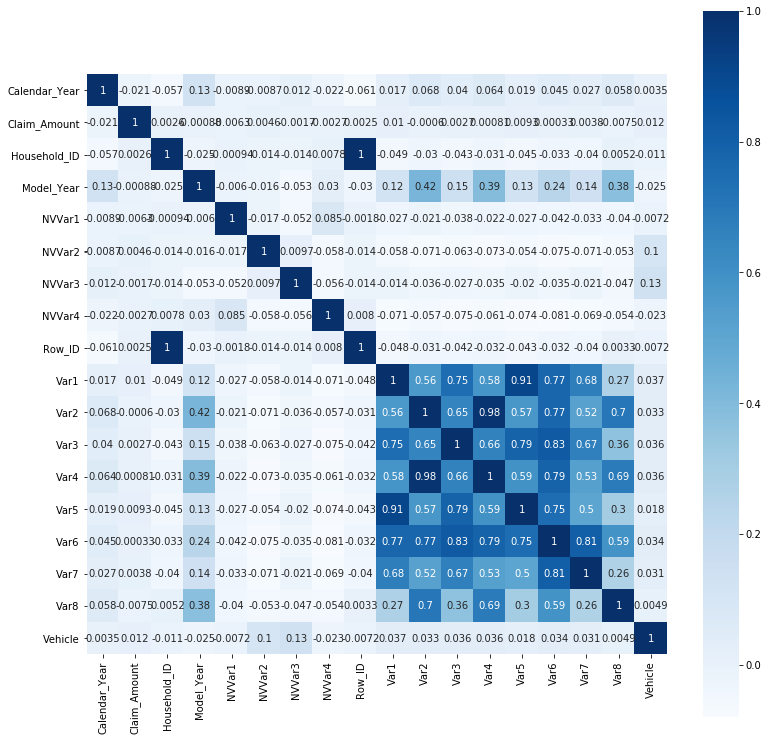

In [18]:
standardS = StandardScaler()
standardS.fit(raw_data_copy_X[continous_columns])
raw_data_copy_train_np = standardS.transform(raw_data_copy_X[continous_columns])
raw_data_copy_train_pd = pd.DataFrame(raw_data_copy_train_np, columns= continous_columns)
raw_data_copy_train_pd_corr = raw_data_copy_train_pd.reindex(sorted(continous_columns),axis=1).corr()
plt.subplots(figsize=(13,13))
sns.heatmap(raw_data_copy_train_pd_corr, annot=True, vmax=1, square=True, cmap="Blues")

In this covariance heatmap, we know that covarinace of some column is pretty large such as cov of `Var2` and `Var4`.<br>
From the scatter of `Var2` and `Var4`, we know that `Var2` and `Var4` are dependent. Also, features `Var*` shown in the heatmap are dependent so we can choose one of them as a feature repersenting `Var*`.

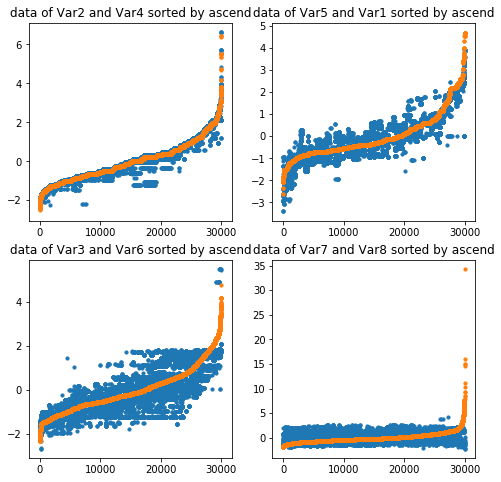

In [19]:
plt.subplots(nrows=2,ncols=2,figsize=(8,8))
varlist = [['Var2','Var4'],['Var5','Var1'],['Var3','Var6'],['Var7','Var8']]
for i,varlistitem in enumerate(varlist):
    index = raw_data_copy_train_pd[varlistitem[1]].sort_values().index.to_numpy()
    n= index.shape[0]
    plt.subplot(2,2,i+1)
    plt.scatter(np.arange(n),raw_data_copy_train_pd.iloc[index][varlistitem[0]], s=10)
    plt.scatter(np.arange(n),raw_data_copy_train_pd.iloc[index][varlistitem[1]], s=10)
    title='data of '+varlistitem[0]+' and '+varlistitem[1]+' sorted by ascend'
    plt.title(title)

The Cov of `Row_ID` and `Household_ID` is equal to 1. That also means `Row_ID` and `Household_ID` are related but `Household_ID` is useless. So,`Row_ID` is also useless.

Text(0.5, 1.0, 'data of Row_ID and Household_ID sorted by ascend')

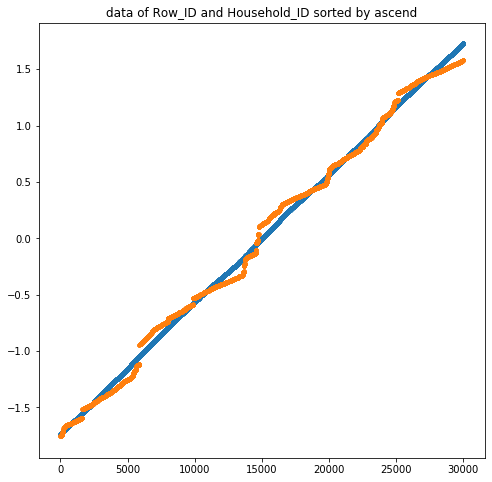

In [20]:
index = raw_data_copy_train_pd['Household_ID'].sort_values().index.to_numpy()
n= index.shape[0]
plt.subplots(figsize=(8,8))
plt.scatter(np.arange(n),raw_data_copy_train_pd.iloc[index]['Row_ID'], s=10)
plt.scatter(np.arange(n),raw_data_copy_train_pd.iloc[index]['Household_ID'], s=10)
plt.title('data of Row_ID and Household_ID sorted by ascend')

From the histogram graph of the dataset, we simply find that some features are roughly splited into two catorgies (zero or non-zero) such as `NVVar*`. The majority values of these columns are 0. Therefore, we can simply discard `NVVar*` columns.

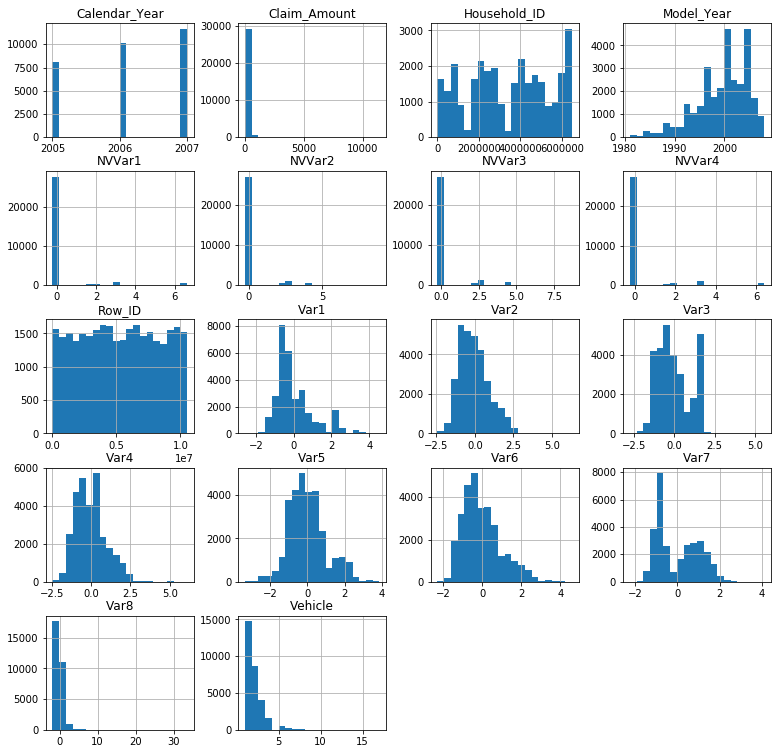

In [21]:
raw_datahist = raw_data_copy.hist(figsize=(13,13),bins=20)

We need to select features form discrete features. Then, we find that `Blind_Make`, `Blind_Submodel` and `Blind_Model` contain a mount of categories so that these column will be abandoned.

In [22]:
print('the number of categories in each column')
for key in discrete_value_count.keys():
    print(key,': ', discrete_value_count[key].count())


the number of categories in each column
Cat8 :  3
OrdCat :  7
Cat1 :  10
Blind_Make :  57
NVCat :  15
Cat3 :  6
Cat6 :  5
Cat10 :  3
Blind_Submodel :  1610
Cat11 :  6
Cat9 :  2
Blind_Model :  835
Cat12 :  6


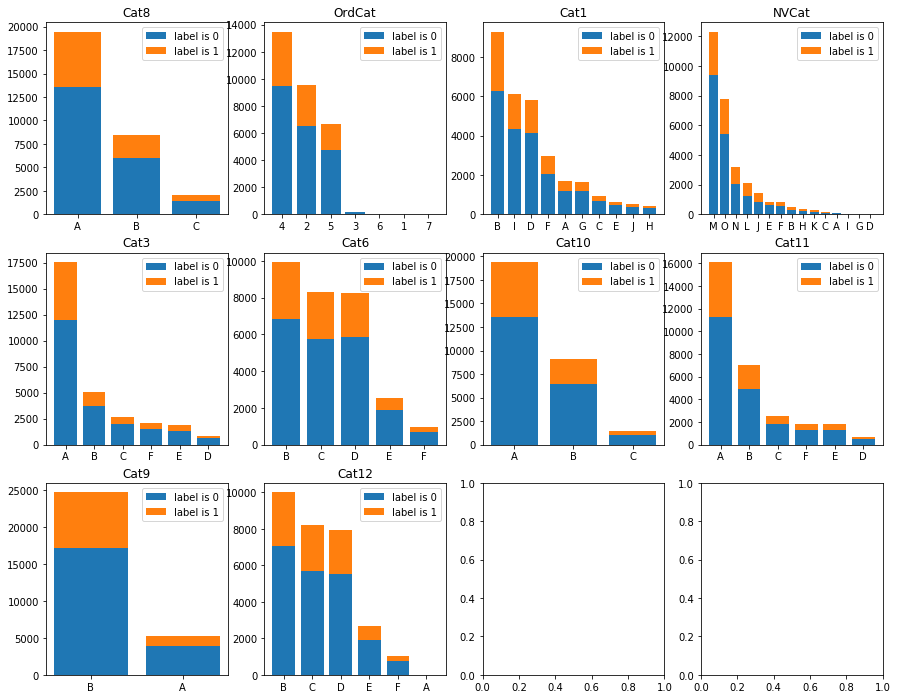

In [23]:
# plot histograms of categorical features
# fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(12,12))
# discrete_columns_processed = discrete_columns-set(['Blind_Make','Blind_Submodel','Blind_Model'])
# for i,item in enumerate(discrete_columns_processed):
#     raw_data_copy[item].value_counts().plot(kind="bar", ax=ax[int(i/4),int(i%4)-1]).set_title(item)
fig, ax = plt.subplots(nrows=3,ncols=4,figsize=(15,12))
discrete_columns_processed = discrete_columns-set(['Blind_Make','Blind_Submodel','Blind_Model'])
pos_raw_data_copy = raw_data_copy[raw_data_copy['Claim_Amount']>0]
neg_raw_data_copy = raw_data_copy[raw_data_copy['Claim_Amount']==0]
for i,item in enumerate(discrete_columns_processed):
    value_count = raw_data_copy[item].value_counts()
    value_count_dict = {ind:value_count[ind] for ind in value_count.index}
    xlen = value_count.shape[0]
    neg_raw_data_copy_list = [neg_raw_data_copy[item].value_counts().get(ckey,0) for ckey in value_count_dict.keys()]
    pos_raw_data_copy_list = [pos_raw_data_copy[item].value_counts().get(ckey,0) for ckey in value_count_dict.keys()]
    plt.subplot(3,4,i+1)
    plt.bar(value_count_dict.keys(),neg_raw_data_copy_list,label='label is 0')
    plt.bar(value_count_dict.keys(),pos_raw_data_copy_list,bottom=neg_raw_data_copy_list,label='label is 1')
    plt.title(item)
    plt.legend()

In [24]:
continous_column_candidates = ['Calendar_Year', 'Model_Year', 'Var2', 'Var5', 'Vehicle','NVVar1','NVVar2']
discrete_column_candidates = ['Cat3', 'Cat11', 'Cat8', 'Cat12', 'Cat6', 'Cat10']

<a name='1-4'></a>
## 1.4 Noramlization & One-hot encoding

In [26]:
selection_data = [continous_column_candidates,discrete_column_candidates]
#selection_data = [continous_column_candidates, discrete_column_candidates]
transformers_regressor = [
        ('num', StandardScaler(), selection_data[0]),
        ('cat', OneHotEncoder(), selection_data[1]),
    ]
transformers_classifier = [
        ('num', StandardScaler(), selection_data[0]),
    ]


In [27]:
# data drop

# pos_index = raw_data_copy[raw_data_copy['Claim_Amount']>0].index.values
# neg_index=raw_data_copy[raw_data_copy['Claim_Amount']==0].index.values
# np.random.shuffle(neg_index)
# data_index_drop = np.concatenate((neg_index_drop[:9000],pos_index))
# np.random.shuffle(data_index_drop)
# raw_data_copy_drop = raw_data_copy.iloc[data_index_drop,:]
# raw_data_copy_Y_binary_drop = raw_data_copy_Y_binary[data_index_drop]


In [28]:


full_transformer = ColumnTransformer(transformers_regressor, remainder='drop')
raw_data_copy_np = full_transformer.fit_transform(raw_data_copy[selection_data[0]+selection_data[1]])

# for item in selection_data[1]:
#     raw_data_copy_np = np.concatenate((raw_data_copy_np,LabelEncoder().fit_transform(raw_data_copy[item]).reshape(-1,1)),axis=1)

## prediction

In [29]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

In [30]:
X_train, X_test, y_train, y_test = train_test_split(raw_data_copy_np, raw_data_copy_Y_binary.to_numpy(), test_size=0.25)
# X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(raw_data_copy_np, raw_data_copy_Y.to_numpy(), test_size=0.25)

In [318]:
DTclassifier = DecisionTreeClassifier(max_depth=10,min_samples_leaf=10)
DTclassifier.fit(X_train,y_train)
DTclassifier.score(X_test,y_test)

0.6864

In [273]:
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train_2,y_train_2)
DTregressor.score(X_train_2,y_train_2)

0.6568297677563334

In [32]:
LR = LinearRegression()
LR.fit(X_train,y_train)
np.sqrt(mean_squared_error(LR.predict(X_test),y_test))

0.45380386881021234

In [275]:
pred = (1/(1+np.exp(-LR.predict(X_test))))
pred[pred>0.5]=1
pred[pred<=0.5]=0
np.sum(pred-y_test)


5218.0

In [33]:
RR = Ridge() 
RR.fit(X_train,y_train)
np.sqrt(mean_squared_error(RR.predict(X_test),y_test))

0.4537983104496148

In [252]:
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)
np.sqrt(mean_squared_error(RFR.predict(X_test),y_test))

289.350261463861

In [253]:
GBR = GradientBoostingRegressor()
GBR.fit(X_train,y_train)
np.sqrt(mean_squared_error(GBR.predict(X_test),y_test))

252.7210343701365

In [349]:
RFC = RandomForestClassifier(min_samples_split=7)
RFC.fit(X_train,y_train)
RFC.score(X_test,y_test)

0.6882666666666667

In [320]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train,y_train)
GBC.score(X_test,y_test)

0.7

In [321]:
RFC_res = RFC.predict(X_test)

In [322]:
np.sum(np.abs(RFC_res-y_test))

2414.0

In [323]:
RFC_res,y_test

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 1., 0., ..., 0., 0., 1.]))

In [350]:
RFC.score(X_train,y_train)

0.8852

In [31]:
X_train,y_train

(array([[-1.38976254, -1.68474192, -0.4950621 , ...,  1.        ,
          0.        ,  0.        ],
        [ 1.09491423,  0.89012483, -0.78310426, ...,  0.        ,
          1.        ,  0.        ],
        [ 1.09491423,  1.28625818,  0.56709328, ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [ 1.09491423,  1.28625818, -0.58507525, ...,  1.        ,
          0.        ,  0.        ],
        [-1.38976254, -1.68474192,  0.02701424, ...,  1.        ,
          0.        ,  0.        ],
        [-1.38976254, -1.28860857,  0.51308541, ...,  0.        ,
          1.        ,  0.        ]]),
 array([0., 0., 1., ..., 1., 1., 0.]))